In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for basic SMILES operations, descriptors and fingerprints
from rdkit import Chem
from rdkit.Chem import Descriptors, MACCSkeys, AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors

# for graphs
import dgl
import torch

# for mol2vec
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

# for chemical language models
from transformers import AutoModel, AutoTokenizer

In [2]:
# load sample of training data for demo
df = pd.read_csv('data/train.csv', nrows=1000)
df.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,0,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,BRD4,0
1,1,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,HSA,0
2,2,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.Br.NCC1CCCN1c1cccnn1,C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...,sEH,0
3,3,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,BRD4,0
4,4,C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21,C#CCOc1ccc(CN)cc1.Cl,Br.NCc1cccc(Br)n1,C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...,HSA,0


In [3]:
# assign unique molecule_smiles values to variable. This is all we need for the purpose of this demo
smiles = df['molecule_smiles'].unique()
print(len(smiles))

334


In [4]:
# obtain RDKit mol objects from SMILES
mols = pd.Series(smiles).apply(Chem.MolFromSmiles)

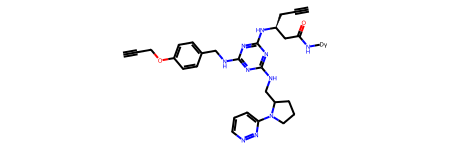

In [5]:
# mol objects can be readily viewed as 2d molecular drawings like so
mols[0]

In [6]:
# generate RDKit descriptors from Mol objects
def generate_descriptors(mols):
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    
    mol_descriptors = []
    for mol in mols:
        rdkit_descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(rdkit_descriptors)
        
    desc_names = calc.GetDescriptorNames()
    return pd.DataFrame(mol_descriptors, columns=desc_names)

descriptor_df = generate_descriptors(mols)
descriptor_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.022584,12.022584,0.147985,-0.351126,0.183859,14.829268,702.124,670.876,703.192320,215,...,0,0,0,2,0,0,0,0,0,0
1,11.915654,11.915654,0.156881,-0.355972,0.156604,10.945946,710.925,686.733,711.049734,193,...,0,0,0,2,0,0,0,0,0,0
2,11.962513,11.962513,0.159820,-0.366334,0.179210,10.675000,685.089,656.865,686.154538,207,...,0,0,0,3,0,0,0,0,0,0
3,11.876213,11.876213,0.144780,-0.380871,0.109711,10.729730,652.060,622.828,653.165437,197,...,0,0,0,2,0,0,0,0,0,0
4,11.954303,11.954303,0.054611,-0.403060,0.142767,10.666667,638.033,610.817,639.149787,191,...,0,0,0,2,0,0,0,0,0,0


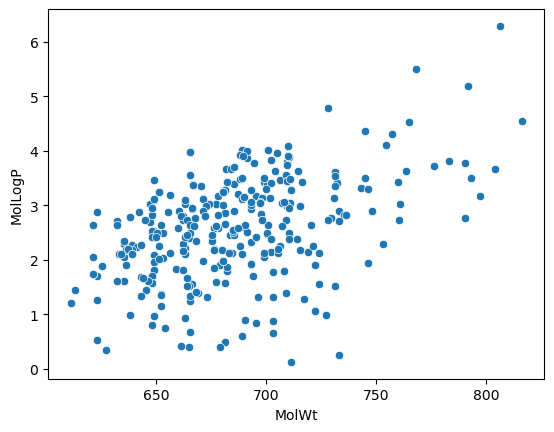

In [7]:
sns.scatterplot(x='MolWt', y='MolLogP', data=descriptor_df)
plt.show()

In [8]:
# generate MACCS Keys from RDKit Mol objects as a dataframe
maccs_list = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]

maccs_data = []
for maccs in maccs_list:
    bit_array = list(map(int, maccs.ToBitString()))
    maccs_data.append(bit_array[1:])  # skip 1st bit as it is unused in RDKit's MACCSkeys.GenMACCSKeys implementation

maccs_df = pd.DataFrame(maccs_data)
maccs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,156,157,158,159,160,161,162,163,164,165
0,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
1,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
2,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
3,0,0,0,0,0,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0


In [9]:
# generate Morgan Fingerprints from RDKit Mol objects as a dataframe
mfpt_list = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in mols]

mfpt_df = pd.DataFrame([list(fpt) for fpt in mfpt_list])
mfpt_df.head()

[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerator
[20:48:47] DEPRECATION WARNING: please use MorganGenerat

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# generate molecular graphs from RDKit Mol objects
def mol_to_dgl_graph(mol):
    graph = dgl.DGLGraph()

    # add nodes
    num_atoms = mol.GetNumAtoms()
    graph.add_nodes(num_atoms)

    # add edges
    for bond in mol.GetBonds():
        # DGL graphs are directed so both directions are added
        graph.add_edges(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        graph.add_edges(bond.GetEndAtomIdx(), bond.GetBeginAtomIdx())

    # add node features - e.g. atomic number
    node_feats = torch.tensor([[atom.GetAtomicNum()] for atom in mol.GetAtoms()], dtype=torch.float32)
    graph.ndata['feat'] = node_feats

    # add edge features (optional) - e.g. bond type: single/double/triple as 1, 2, 3
    edge_feats = []
    for bond in mol.GetBonds():
        bond_type = bond.GetBondTypeAsDouble()
        edge_feats.append([bond_type])
        edge_feats.append([bond_type])  # add both directions
    graph.edata['type'] = torch.tensor(edge_feats, dtype=torch.float32)

    return graph

graphs = mols.apply(mol_to_dgl_graph)
print(graphs)

d:\jupyter notebook\Lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


0      Graph(num_nodes=41, num_edges=88,\n      ndata...
1      Graph(num_nodes=37, num_edges=78,\n      ndata...
2      Graph(num_nodes=40, num_edges=84,\n      ndata...
3      Graph(num_nodes=37, num_edges=76,\n      ndata...
4      Graph(num_nodes=36, num_edges=74,\n      ndata...
                             ...                        
329    Graph(num_nodes=38, num_edges=80,\n      ndata...
330    Graph(num_nodes=37, num_edges=78,\n      ndata...
331    Graph(num_nodes=40, num_edges=86,\n      ndata...
332    Graph(num_nodes=38, num_edges=80,\n      ndata...
333    Graph(num_nodes=39, num_edges=84,\n      ndata...
Length: 334, dtype: object


In [11]:
# graph neural networks typically process graphs in batches for efficiency
batched_graph = dgl.batch(graphs.tolist())
batched_graph

Graph(num_nodes=12998, num_edges=27500,
      ndata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'type': Scheme(shape=(1,), dtype=torch.float32)})

In [12]:
# load pre-trained mol2vec model
mol2vec_path = 'model_300dim.pkl'
mol2vec_model = word2vec.Word2Vec.load(mol2vec_path)

In [13]:
# generate molecular sentences
mol_sentences = mols.apply(lambda x: MolSentence(mol2alt_sentence(x, 1)))

# version of sentences2vec() compatible with gensim v4.0 (source: https://github.com/samoturk/mol2vec/issues/14)
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.
    
    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """
    
    keys = set(model.wv.key_to_index)
    vec = []
    
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys]))
    return np.array(vec)

# generate vector embeddings from molecular sentences
mol2vec_embeddings = np.array([DfVec(x) for x in sentences2vec(mol_sentences, mol2vec_model, unseen='UNK')])
mol2vec_embeddings[:5]

[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerator
[21:08:50] DEPRECATION WARNING: please use MorganGenerat

array([(300,) dimensional vector, (300,) dimensional vector,
       (300,) dimensional vector, (300,) dimensional vector,
       (300,) dimensional vector], dtype=object)

In [14]:
# load pre-trained ChemBERTa model checkpoint and tokenizer
cb_tokenizer = AutoTokenizer.from_pretrained('DeepChem/ChemBERTa-10M-MLM')
cb_model = AutoModel.from_pretrained('DeepChem/ChemBERTa-10M-MLM')
cb_model.eval()

# tokenize SMILES
cb_encoded_inputs = cb_tokenizer(list(smiles), padding=True, truncation=True, return_tensors="pt")

# calculate embeddings
with torch.no_grad():
    outputs = cb_model(**cb_encoded_inputs)

# extract pooled output
cb_embeddings = outputs.pooler_output

cb_embeddings_df = pd.DataFrame(cb_embeddings.numpy())
cb_embeddings_df.head()

d:\jupyter notebook\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\PC\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.033255,0.304024,0.028674,0.454310,0.374800,-0.083185,-0.543557,0.169592,0.245265,0.309248,...,-0.130627,-0.009090,0.314032,0.087740,-0.021144,-0.081401,-0.309438,0.153413,-0.286025,0.519041
1,-0.082345,0.330427,0.011730,0.374080,0.383693,-0.193294,-0.579864,0.252878,0.269512,0.235254,...,-0.027331,-0.071470,0.228626,0.040383,-0.134836,-0.204418,-0.406058,0.119706,-0.342370,0.474874
2,-0.118672,0.264707,0.000555,0.430303,0.349721,-0.149895,-0.557703,0.195016,0.298554,0.284716,...,-0.021225,-0.065929,0.161207,0.082658,-0.157228,-0.126546,-0.433643,0.150882,-0.305696,0.494248
3,-0.216757,0.292265,-0.002974,0.441646,0.324276,-0.086984,-0.562753,0.090501,0.337229,0.282486,...,-0.091632,-0.010783,0.205575,0.183194,-0.093209,-0.136981,-0.205050,0.176757,-0.161318,0.463382
4,-0.218816,0.280228,-0.001317,0.487322,0.303871,-0.089765,-0.604180,0.128424,0.317202,0.310026,...,-0.050356,-0.021517,0.124383,0.106647,-0.111470,-0.140084,-0.343978,0.259923,-0.194000,0.429021


In [ ]:
# load pre-trained MolFormer model checkpoint and tokenizer
mf_tokenizer = AutoTokenizer.from_pretrained('ibm/MoLFormer-XL-both-10pct', deterministic_eval=True, trust_remote_code=True)
mf_model = AutoModel.from_pretrained('ibm/MoLFormer-XL-both-10pct', trust_remote_code=True)

# tokenize SMILES
mf_encoded_inputs = mf_tokenizer(list(smiles), padding=True, return_tensors="pt")

# calculate embeddings
with torch.no_grad():
    outputs = mf_model(**mf_encoded_inputs)

# extract embeddings
mf_embeddings = outputs.pooler_output

mf_embeddings_df = pd.DataFrame(mf_embeddings.numpy())
mf_embeddings_df.head()